In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_multigrid_fixed'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfc05c1fd0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfc21d4630>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.679    |
| time/              |          |
|    fps             | 447      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 35 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.667       |
| time/                   |             |
|    fps                  | 481         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                 

policy iteration runtime: 34 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.726      |
| time/                   |            |
|    fps                  | 455        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05085764 |
|    clip_fraction        | 0.485      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.07       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0631    |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0447    |
|    std                  | 0.181      |
|    value_loss           | 

policy iteration runtime: 32 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.744       |
| time/                   |             |
|    fps                  | 459         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.048280817 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.37        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0503     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0428     |
|    std                  | 

policy iteration runtime: 34 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.772       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058969725 |
|    clip_fraction        | 0.552       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.61        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000243   |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0431     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.781       |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.059190728 |
|    clip_fraction        | 0.58        |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.03        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0412     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0407     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.797      |
| time/                   |            |
|    fps                  | 463        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07169143 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.55       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0213    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0369    |
|    std                  | 0.17       |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.811      |
| time/                   |            |
|    fps                  | 466        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07091652 |
|    clip_fraction        | 0.585      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.11       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0485    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0322    |
|    std                  | 0.166      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.817      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07097624 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0584    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0304    |
|    std                  | 0.159      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.822      |
| time/                   |            |
|    fps                  | 474        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06982125 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0563    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0245    |
|    std                  | 0.155      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 484        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09430981 |
|    clip_fraction        | 0.608      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0428    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0217    |
|    std                  | 0.15       |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.082806155 |
|    clip_fraction        | 0.612       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.1        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0101      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0213     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06973883 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0317    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0185    |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08045194 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0329    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0186    |
|    std                  | 0.14       |
|    

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfc21d4630> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfc05b0390>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 368        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09031649 |
|    clip_fraction        | 0.614      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00342    |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.0196    |
|    std                  | 0.14       |
|    value_loss           | 0.000703   |
---------------------------------

policy iteration runtime: 27 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 394        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10799937 |
|    clip_fraction        | 0.618      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0156     |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0199    |
|    std                  | 0.138      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09702243 |
|    clip_fraction        | 0.621      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0806    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0182    |
|    std                  | 0.135      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 391        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10151513 |
|    clip_fraction        | 0.618      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0693    |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0189    |
|    std                  | 0.135      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 375         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.102157906 |
|    clip_fraction        | 0.63        |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.9        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0627     |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.023      |
|    std                  | 0.134       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 386        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12010454 |
|    clip_fraction        | 0.64       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0151    |
|    n_updates            | 2760       |
|    policy_gradient_loss | -0.0172    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 27 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 368        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12523279 |
|    clip_fraction        | 0.633      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0691    |
|    n_updates            | 2920       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.131      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 78848

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 396         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.108279034 |
|    clip_fraction        | 0.648       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.5        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00864     |
|    n_updates            | 3080        |
|    policy_gradient_loss | -0.0188     |
|    std                  | 0.131       |
|    va

policy iteration runtime: 27 seconds

Total episode rollouts: 82944

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 362         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.116100594 |
|    clip_fraction        | 0.647       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.7        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0331     |
|    n_updates            | 3240        |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.129       |
|    va

policy iteration runtime: 28 seconds

Total episode rollouts: 87040

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 398        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12772503 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0524    |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 91136

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.846       |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.101454474 |
|    clip_fraction        | 0.657       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.2        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.021       |
|    n_updates            | 3560        |
|    policy_gradient_loss | -0.0148     |
|    std                  | 0.126       |
|    va

Early stopping at step 19 due to reaching max kl: 0.15
policy iteration runtime: 28 seconds

Total episode rollouts: 95232

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 370        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15281372 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0418    |
|    n_updates            | 3720       |
|    policy_gradient_loss | -0.0128    |
|    std     

policy iteration runtime: 31 seconds

Total episode rollouts: 99328

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13211091 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0184     |
|    n_updates            | 3880       |
|    policy_gradient_loss | -0.0122    |
|    std                  | 0.122      |
|    value_loss           |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfc21d4518> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfac0969b0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 204        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11214262 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0221    |
|    n_updates            | 3920       |
|    policy_gradient_loss | -0.0126    |
|    std                  | 0.123      |
|    value_loss           | 0.00062    |
---------------------------------

policy iteration runtime: 31 seconds

Total episode rollouts: 104448

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 229        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13471368 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0373     |
|    n_updates            | 4080       |
|    policy_gradient_loss | -0.0157    |
|    std                  | 0.122      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 29 seconds

Total episode rollouts: 108544

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 225        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15774678 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.034      |
|    n_updates            | 4240       |
|    policy_gradient_loss | -0.013     |
|    std    

policy iteration runtime: 33 seconds

Total episode rollouts: 112640

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.853     |
| time/                   |           |
|    fps                  | 228       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1268824 |
|    clip_fraction        | 0.661     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.2      |
|    explained_variance   | 0.986     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0348   |
|    n_updates            | 4400      |
|    policy_gradient_loss | -0.0165   |
|    std                  | 0.121     |
|    value_loss           | 0.000904  |
------

policy iteration runtime: 36 seconds

Total episode rollouts: 116736

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 224        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14198577 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0178     |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.0173    |
|    std                  | 0.12       |
|   

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 36 seconds

Total episode rollouts: 120832

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 219        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15129542 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0761     |
|    n_updates            | 4720       |
|    policy_gradient_loss | -0.

Early stopping at step 15 due to reaching max kl: 0.16
policy iteration runtime: 33 seconds

Total episode rollouts: 124928

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 220        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16166265 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0338     |
|    n_updates            | 4880       |
|    policy_gradient_loss | -0.00398   |
|    std    

policy iteration runtime: 38 seconds

Total episode rollouts: 129024

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 222        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13650218 |
|    clip_fraction        | 0.694      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0317    |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.00981   |
|    std                  | 0.118      |
|   

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 133120

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 232        |
|    iterations           | 1          |
|    time_elapsed         | 10         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15429273 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.025      |
|    n_updates            | 5200       |
|    policy_gradient_loss | -0.

policy iteration runtime: 32 seconds

Total episode rollouts: 137216

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14555785 |
|    clip_fraction        | 0.684      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0705    |
|    n_updates            | 5360       |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.118      |
|   

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 33 seconds

Total episode rollouts: 141312

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 223        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16088477 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0422    |
|    n_updates            | 5520       |
|    policy_gradient_loss | -0.0129    |
|    std    

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 28 seconds

Total episode rollouts: 145408

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 219        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15001795 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0205    |
|    n_updates            | 5680       |
|    policy_gradient_loss | -0.00602   |
|    std    

policy iteration runtime: 33 seconds

Total episode rollouts: 149504

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 222        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13091871 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0177    |
|    n_updates            | 5840       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.118      |
|    value_loss           

<IPython.core.display.Javascript object>


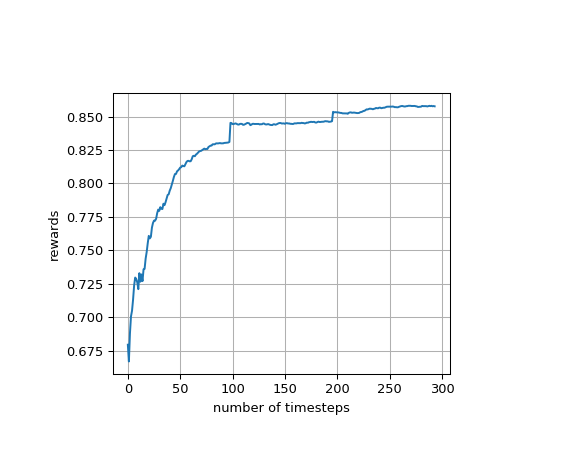

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfac096b00> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfc05b9908>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.671      |
| time/                   |            |
|    fps                  | 462        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15899126 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0455    |
|    n_updates            | 5880       |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.118      |
|    value_loss           | 0.00112    |
---------------------------------

policy iteration runtime: 28 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.726       |
| time/                   |             |
|    fps                  | 477         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.043623336 |
|    clip_fraction        | 0.498       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.04        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0403     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0475     |
|    std                  | 

policy iteration runtime: 26 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.731     |
| time/                   |           |
|    fps                  | 462       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0551486 |
|    clip_fraction        | 0.51      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.24      |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0647   |
|    n_updates            | 320       |
|    policy_gradient_loss | -0.0444   |
|    std                  | 0.18      |
|    value_loss           | 0.0014    |
--------

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.745       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.056733884 |
|    clip_fraction        | 0.546       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.67        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0635     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0432     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.756     |
| time/                   |           |
|    fps                  | 465       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0666964 |
|    clip_fraction        | 0.57      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.97      |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0621   |
|    n_updates            | 640       |
|    policy_gradient_loss | -0.0435   |
|    std                  | 0.174     |
|    value_loss          

policy iteration runtime: 26 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.77       |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07357506 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.38       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0834    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0399    |
|    std                  | 0.171      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.791     |
| time/                   |           |
|    fps                  | 474       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0922491 |
|    clip_fraction        | 0.594     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.88      |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0583   |
|    n_updates            | 960       |
|    policy_gradient_loss | -0.0338   |
|    std                  | 0.167     |
|    value_loss          

policy iteration runtime: 34 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.812       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083682366 |
|    clip_fraction        | 0.614       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.58        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0335     |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0345     |
|    std                  |

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.825      |
| time/                   |            |
|    fps                  | 487        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07787631 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.4        |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00189   |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.156      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 470         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.090517186 |
|    clip_fraction        | 0.603       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0208     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0181     |
|    std                  |

policy iteration runtime: 32 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 468        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09132691 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0557     |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0149    |
|    std                  | 0.146      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.833       |
| time/                   |             |
|    fps                  | 482         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.086456716 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.4        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0332     |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0134     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.835     |
| time/                   |           |
|    fps                  | 462       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1063107 |
|    clip_fraction        | 0.614     |
|    clip_range           | 0.15      |
|    entropy_loss         | 11.9      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0178    |
|    n_updates            | 1920      |
|    policy_gradient_loss | -0.0117   |
|    std                  | 0.139     |
|    value_loss          

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfc05a7e48> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfac06e748>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10190296 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12         |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0762    |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.00856   |
|    std                  | 0.139      |
|    value_loss           | 0.000501   |
---------------------------------

policy iteration runtime: 34 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.847       |
| time/                   |             |
|    fps                  | 396         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.106239974 |
|    clip_fraction        | 0.643       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.3        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0265     |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.017      |
|    std                  |

policy iteration runtime: 28 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 394        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10602144 |
|    clip_fraction        | 0.639      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0212    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0157    |
|    std                  | 0.133      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 395        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07224054 |
|    clip_fraction        | 0.64       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.026      |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.131      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 397        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10320632 |
|    clip_fraction        | 0.634      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0654    |
|    n_updates            | 2600       |
|    policy_gradient_loss | -0.0125    |
|    std                  | 0.13       |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.849       |
| time/                   |             |
|    fps                  | 386         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.113078274 |
|    clip_fraction        | 0.648       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.6        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0545     |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0146     |
|    std                  | 0.129       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09846366 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0729    |
|    n_updates            | 2920       |
|    policy_gradient_loss | -0.0145    |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 78848

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10156916 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.8       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0772     |
|    n_updates            | 3080       |
|    policy_gradient_loss | -0.0148    |
|    std                  | 0.127      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 82944

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 372        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12448232 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0178    |
|    n_updates            | 3240       |
|    policy_gradient_loss | -0.0146    |
|    std                  | 0.125      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 87040

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12810943 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0279    |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0127    |
|    std                  | 0.123      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 91136

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.851     |
| time/                   |           |
|    fps                  | 378       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1292787 |
|    clip_fraction        | 0.662     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.7      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0248   |
|    n_updates            | 3560      |
|    policy_gradient_loss | -0.0119   |
|    std                  | 0.122     |
|    value_loss           | 0.000766  |
-------

policy iteration runtime: 28 seconds

Total episode rollouts: 95232

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13652548 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.142      |
|    n_updates            | 3720       |
|    policy_gradient_loss | -0.012     |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 99328

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.852       |
| time/                   |             |
|    fps                  | 345         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.107817195 |
|    clip_fraction        | 0.659       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.9        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00387    |
|    n_updates            | 3880        |
|    policy_gradient_loss | -0.00805    |
|    std                  | 0.121       |
|    va

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfac093908> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcf8c191358>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.858       |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.110686935 |
|    clip_fraction        | 0.669       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.9        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0269      |
|    n_updates            | 3920        |
|    policy_gradient_loss | -0.00977    |
|    std                  | 0.121       |
|    value_loss           | 0.000681    |
------------

policy iteration runtime: 38 seconds

Total episode rollouts: 104448

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 227        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10151799 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0417    |
|    n_updates            | 4080       |
|    policy_gradient_loss | -0.0119    |
|    std                  | 0.122      |
|    value_loss           

policy iteration runtime: 37 seconds

Total episode rollouts: 108544

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 222        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13708356 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0217     |
|    n_updates            | 4240       |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.122      |
|    value_loss           

policy iteration runtime: 39 seconds

Total episode rollouts: 112640

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 228        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12864698 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0724    |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 40 seconds

Total episode rollouts: 116736

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 227        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11814336 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0711    |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.0141    |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 37 seconds

Total episode rollouts: 120832

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.859     |
| time/                   |           |
|    fps                  | 223       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1392103 |
|    clip_fraction        | 0.675     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.2      |
|    explained_variance   | 0.986     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0451   |
|    n_updates            | 4720      |
|    policy_gradient_loss | -0.0163   |
|    std                  | 0.12      |
|    value_loss           | 0.000982  |
------

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 34 seconds

Total episode rollouts: 124928

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 221        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15117581 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.033      |
|    n_updates            | 4880       |
|    policy_gradient_loss | -0.

policy iteration runtime: 33 seconds

Total episode rollouts: 129024

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 221        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14502235 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00939   |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 133120

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 220        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14187829 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0538    |
|    n_updates            | 5200       |
|    policy_gradient_loss | -0.0146    |
|    std                  | 0.119      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 137216

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.859     |
| time/                   |           |
|    fps                  | 215       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1604127 |
|    clip_fraction        | 0.66      |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.4      |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0455   |
|    n_updates            | 5360      |
|    policy_gradient_loss | -0.00923  |
|    std                  | 0.1

policy iteration runtime: 33 seconds

Total episode rollouts: 141312

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 205        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13025698 |
|    clip_fraction        | 0.68       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.214      |
|    n_updates            | 5520       |
|    policy_gradient_loss | -0.0162    |
|    std                  | 0.118      |
|    value_loss           

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 32 seconds

Total episode rollouts: 145408

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 210        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15194206 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.006     |
|    n_updates            | 5680       |
|    policy_gradient_loss | -0.008     |
|    std    

Early stopping at step 12 due to reaching max kl: 0.16
policy iteration runtime: 30 seconds

Total episode rollouts: 149504

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1          |
|    time_elapsed         | 13         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15694752 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0592    |
|    n_updates            | 5840       |
|    policy_gradient_loss | -0.00894   |
|    std    

<IPython.core.display.Javascript object>

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfac096438> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcf8c1aaeb8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.68       |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14545372 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0136     |
|    n_updates            | 5880       |
|    policy_gradient_loss | -0.00963   |
|    std                  | 0.117      |
|    value_loss           | 0.000978   |
---------------------------------

policy iteration runtime: 26 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.719       |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.041048933 |
|    clip_fraction        | 0.485       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.9         |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0689     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0463     |
|    std                  | 0.183       |
|    val

policy iteration runtime: 34 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.741      |
| time/                   |            |
|    fps                  | 467        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04647106 |
|    clip_fraction        | 0.523      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.21       |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0857    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0442    |
|    std                  | 0.18       |
|    value_loss           | 

policy iteration runtime: 32 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.762     |
| time/                   |           |
|    fps                  | 483       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0578928 |
|    clip_fraction        | 0.548     |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.57      |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0349   |
|    n_updates            | 480       |
|    policy_gradient_loss | -0.0449   |
|    std                  | 0.177     |
|    value_loss          

policy iteration runtime: 31 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058915943 |
|    clip_fraction        | 0.574       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.02        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00935     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0415     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.79       |
| time/                   |            |
|    fps                  | 462        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06914873 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.64       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0381    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0374    |
|    std                  | 0.169      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.799       |
| time/                   |             |
|    fps                  | 466         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.070667684 |
|    clip_fraction        | 0.593       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.38        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0254     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0338     |
|    std                  |

policy iteration runtime: 33 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.807      |
| time/                   |            |
|    fps                  | 485        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08583589 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0376    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0335    |
|    std                  | 0.159      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.813      |
| time/                   |            |
|    fps                  | 486        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07361041 |
|    clip_fraction        | 0.613      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0646    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.154      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.818       |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.089062504 |
|    clip_fraction        | 0.611       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0416     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0232     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.821      |
| time/                   |            |
|    fps                  | 468        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08019618 |
|    clip_fraction        | 0.617      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0501    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0211    |
|    std                  | 0.146      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.823      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10313401 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.4       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0191     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.023     |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 27 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.825       |
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.095734775 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.8        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0521     |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.139       |
|    va

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcf8c1aaeb8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcfac093c50>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 374        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08722533 |
|    clip_fraction        | 0.613      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0443    |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.0185    |
|    std                  | 0.139      |
|    value_loss           | 0.000631   |
---------------------------------

policy iteration runtime: 28 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.84        |
| time/                   |             |
|    fps                  | 381         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.106690384 |
|    clip_fraction        | 0.625       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.4        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.016      |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.0196     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.842      |
| time/                   |            |
|    fps                  | 384        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11858334 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0157    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0203    |
|    std                  | 0.134      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 379        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10975508 |
|    clip_fraction        | 0.639      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0701    |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0214    |
|    std                  | 0.132      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10255019 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0475    |
|    n_updates            | 2600       |
|    policy_gradient_loss | -0.0201    |
|    std                  | 0.13       |
|    

policy iteration runtime: 29 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.846       |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.105483726 |
|    clip_fraction        | 0.646       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.6        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0511     |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0193     |
|    std                  |

policy iteration runtime: 28 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 386        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13207798 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0083    |
|    n_updates            | 2920       |
|    policy_gradient_loss | -0.0166    |
|    std                  | 0.127      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 78848

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 389        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11461739 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14         |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0425    |
|    n_updates            | 3080       |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.126      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 82944

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 365        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11350089 |
|    clip_fraction        | 0.64       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0404    |
|    n_updates            | 3240       |
|    policy_gradient_loss | -0.0147    |
|    std                  | 0.125      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 87040

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 386        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10138321 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0703    |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0148    |
|    std                  | 0.123      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 91136

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 387        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12020467 |
|    clip_fraction        | 0.652      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0374    |
|    n_updates            | 3560       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 95232

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13741332 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0326    |
|    n_updates            | 3720       |
|    policy_gradient_loss | -0.0215    |
|    std                  | 0.12       |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 99328

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 387        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12373278 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0505    |
|    n_updates            | 3880       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.119      |
|    value_loss           |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fcfac093c50> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fcf8c0d5630>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 218       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1401315 |
|    clip_fraction        | 0.674     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.5      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0312    |
|    n_updates            | 3920      |
|    policy_gradient_loss | -0.0159   |
|    std                  | 0.118     |
|    value_loss           | 0.000738  |
---------------------------------------
Early stopping

policy iteration runtime: 40 seconds

Total episode rollouts: 104448

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 228       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1479481 |
|    clip_fraction        | 0.674     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.7      |
|    explained_variance   | 0.982     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0539   |
|    n_updates            | 4080      |
|    policy_gradient_loss | -0.015    |
|    std                  | 0.117     |
|    value_loss           | 0.00106   |
------

policy iteration runtime: 38 seconds

Total episode rollouts: 108544

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 225        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13630143 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0587    |
|    n_updates            | 4240       |
|    policy_gradient_loss | -0.00901   |
|    std                  | 0.117      |
|   

policy iteration runtime: 37 seconds

Total episode rollouts: 112640

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11477604 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0314    |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0135    |
|    std                  | 0.116      |
|    value_loss           

policy iteration runtime: 33 seconds

Total episode rollouts: 116736

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 232        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13571846 |
|    clip_fraction        | 0.682      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0881    |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.016     |
|    std                  | 0.115      |
|    value_loss           

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 36 seconds

Total episode rollouts: 120832

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 221        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15096202 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0688     |
|    n_updates            | 4720       |
|    policy_gradient_loss | -0.0101    |
|    std    

policy iteration runtime: 32 seconds

Total episode rollouts: 124928

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12973897 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.061     |
|    n_updates            | 4880       |
|    policy_gradient_loss | -0.0122    |
|    std                  | 0.115      |
|    value_loss           

Early stopping at step 11 due to reaching max kl: 0.15
policy iteration runtime: 28 seconds

Total episode rollouts: 129024

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 222        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15254687 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00377   |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.00012   |
|    std    

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 133120

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.858     |
| time/                   |           |
|    fps                  | 218       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1529445 |
|    clip_fraction        | 0.668     |
|    clip_range           | 0.15      |
|    entropy_loss         | 16.3      |
|    explained_variance   | 0.984     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0157    |
|    n_updates            | 5200      |
|    policy_gradient_loss | -0.000344 |
|    std                  | 0.1

policy iteration runtime: 32 seconds

Total episode rollouts: 137216

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 222        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14492278 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0841    |
|    n_updates            | 5360       |
|    policy_gradient_loss | -0.0071    |
|    std                  | 0.114      |
|    value_loss           

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 35 seconds

Total episode rollouts: 141312

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 223        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15121508 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0425     |
|    n_updates            | 5520       |
|    policy_gradient_loss | -0.00728   |
|    std    

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 34 seconds

Total episode rollouts: 145408

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 223        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15981121 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.115      |
|    n_updates            | 5680       |
|    policy_gradient_loss | -0.00821   |
|    std    

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 30 seconds

Total episode rollouts: 149504

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 220        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15255669 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.019     |
|    n_updates            | 5840       |
|    policy_gradient_loss | -0.

<IPython.core.display.Javascript object>

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[50000, 50000, 50000], 
                                log_dir=log_dir,
                                seed=seed)